In [52]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.cluster import KMeans 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk 
import string
from wordcloud import WordCloud

### **Import and Inspect Data**

In [37]:
df = pd.read_csv('/Users/kelvinfoo/Desktop/AISG Technical Assignments/Topic Modelling of Consumer Complaints/complaints_sample.csv')
df = df[['date_received', 'consumer_complaint_narrative', 'company', 'state']]
df.head()

,date_received,consumer_complaint_narrative,company,state
0,2020-05-31,ADDRESS ON THE ATTACHMENT ITR DOES NOT BELONG ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA
1,2020-06-05,"There is inaccurate, misleading, incorrect, ou...","EQUIFAX, INC.",TX
2,2020-06-02,To : Whom It May concern : I am writing to dis...,Experian Information Solutions Inc.,CA
3,2019-12-12,I recently reviewed my credit profile and noti...,Experian Information Solutions Inc.,CA
4,2020-02-11,I sent TransUnion a letter requesting my infor...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MD


In [5]:
df.isnull().sum()

date_received                    0
consumer_complaint_narrative     0
company                          0
state                           29
dtype: int64

- There was 29 submissions where no state was mentioned.

### **Preprocessing of Consumer Complaints**

In [38]:
complaints = df['consumer_complaint_narrative']

In [39]:
# Make text lowercase, remove punctuation and remove words containing numbers.
def clean_text(text): 
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

complaints = complaints.apply(lambda x: clean_text(x))

In [40]:
stop_words_adjusted = list(text.ENGLISH_STOP_WORDS.union(['xx', 'xxxx', 'xxxxxx', 'xxxxxxxx', '00', '01', '000', '06', '09', '10', '100', '1000', '10000', '100000', '1001']))

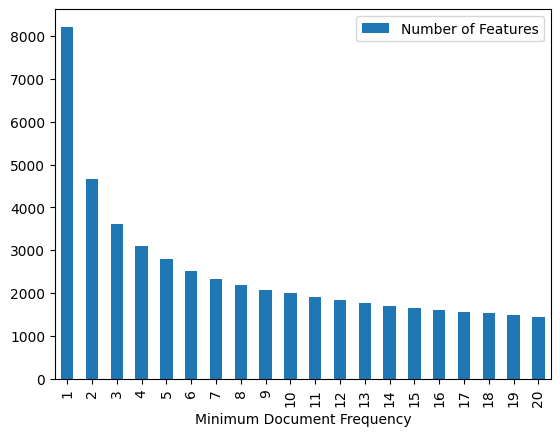

In [41]:
# Determine optimal min doc frequency to use in Tf-idf vectorizer 
min_doc_frequencies = []

for i in range(1, 21): 
    tfidf_vectorizer = TfidfVectorizer(stop_words= stop_words_adjusted, min_df = i)
    dtm = tfidf_vectorizer.fit(complaints)
    min_doc_frequencies.append([i, len(tfidf_vectorizer.get_feature_names_out())])

min_freqs_df = pd.DataFrame(min_doc_frequencies, columns = ['Minimum Document Frequency', 'Number of Features'])

min_freqs_df.plot(x = 'Minimum Document Frequency', y = 'Number of Features', kind = 'bar')
plt.show()

- As minimum document frequency increases beyond 4, the rate of decrease in number of features become smaller. Hence, we pick minimum document frequency = 4.

In [42]:
tfidf_vectorizer = TfidfVectorizer(stop_words= stop_words_adjusted, min_df = 4)
complaints_dtm = tfidf_vectorizer.fit_transform(complaints)

In [43]:
# Identify most import features 
complaints_dtm_df = pd.DataFrame(complaints_dtm.toarray())
complaints_dtm_df.columns = tfidf_vectorizer.get_feature_names_out()

term_weights = pd.DataFrame(complaints_dtm_df.sum(axis = 0))
term_weights = term_weights.reset_index()
term_weights.columns = ['Term', 'Sum of Weights']
top_features = term_weights.sort_values('Sum of Weights', ascending = False)
top_features.head(10)

,Term,Sum of Weights
672,credit,419.174057
30,accounts,348.746545
26,account,310.200250
2338,report,308.210556
1432,information,238.519588
2344,reporting,207.839412
1357,identity,166.617630
2318,remove,154.816928
2768,theft,152.869188
1179,fraudulent,151.216327


### **Topic Modelling with K-Means Clsutering**

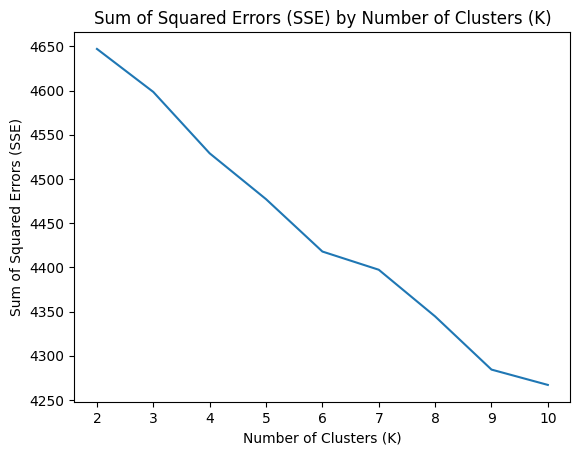

In [44]:
# Find optimal number of clusters using sum of squared errors and silhouette score 
k_value = range(2,11)
sse = []
silhouette = []

for i in k_value: 
    k_means = KMeans(random_state = 42, n_clusters = i, max_iter = 50)
    sse.append(k_means.fit(complaints_dtm).inertia_)
    silhouette.append(silhouette_score(complaints_dtm, k_means.fit_predict(complaints_dtm), metric = 'euclidean'))

plt.plot(k_value, sse)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Sum of Squared Errors (SSE) by Number of Clusters (K)')
plt.show()

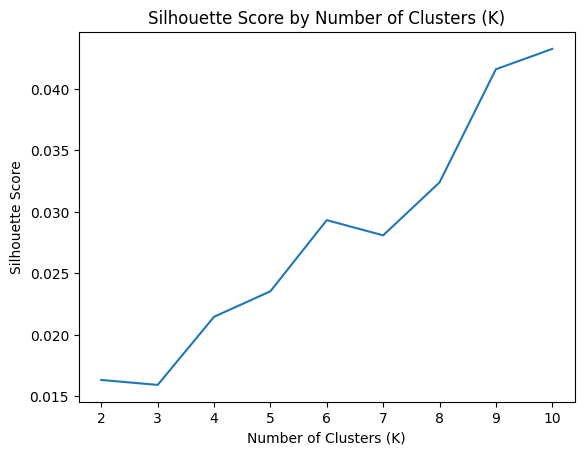

In [45]:
plt.plot(k_value, silhouette)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters (K)')
plt.show()

- Unable to determine optimal number of clusters using sum of squared errors and silhouette scores.

### **Topic Modelling with LDA**

In [48]:
for i in range(2, 5): 
    lda = LatentDirichletAllocation(n_components=i, random_state=42)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    number_words = 25
    alpha = lda.fit_transform(complaints_dtm)
    beta = lda.components_

    print("\n")
    print("Results with ",i," topics:")
    print("\n")

    for topic_index, topic in enumerate(lda.components_): 
        message = "Topic #%d: " % topic_index    # getting the topic number
        
        message += " ".join([feature_names[i] for i in topic.argsort()[:-number_words - 1:-1]])  # getting the list of top words for that topic
        message += "\n"   ## adding space for readability

        print(message)



Results with  2  topics:


Topic #0: accounts credit report identity theft remove items victim fraudulent inquiries belong file consumer information listed pulled unknown ftc open did police reporting does companies derogatory

Topic #1: account credit information reporting report late balance bureaus reported payment paid dispute experian company removed opened debt loan inaccurate letter payments date sent acct incorrect



Results with  3  topics:


Topic #0: theft identity victim accounts report consumer credit ftc listed information file block items section result reporting does remove fraudulent police following id belong blocked relate

Topic #1: account credit information reporting report late balance bureaus reported payment experian removed paid dispute company debt inaccurate opened letter date payments loan fraudulent incorrect sent

Topic #2: accounts credit report items remove inquiries open fraudulent pulled did belong unknown oh soon derogatory possible time social ne

- For results with 3 topics, there was an overlap in the three topics such that they contain complaints related to fraud.
- For results with 4 topics, topic 0 and topic 4 overlapped such that they contained complaints about identity theft.
- Results with 2 topics resulted in the best seperation of topics. Topic 0 contained complaints on fraud and identity theft while topic 1 contained complaints on late payment or incorrect payment status.

In [49]:
lda = LatentDirichletAllocation(n_components=2, random_state =42)
alpha = lda.fit_transform(complaints_dtm)

alpha_df = pd.DataFrame(alpha)
alpha_df['Max'] = alpha_df.idxmax(axis=1)
alpha_df.groupby(by='Max').agg('count')[0]

Max
0    1948
1    3052
Name: 0, dtype: int64

- There were 1948 complaints related to fraud and identity theft and 3052 complaints related to late payment and incorrect payment status.

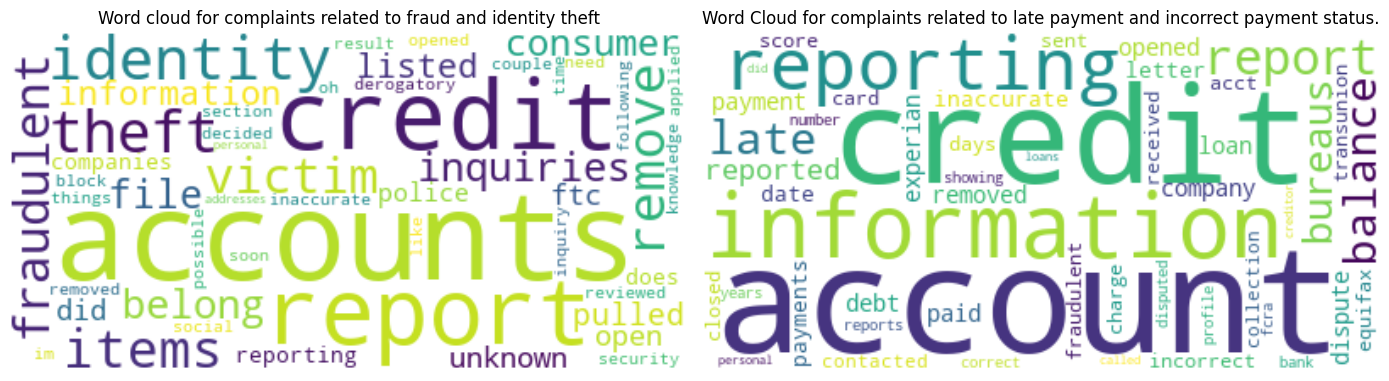

In [56]:
def generate_wordcloud(topic_idx):
    topic = lda.components_[topic_idx]  
    top_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-51:-1]}  
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(top_words)  
    return wordcloud

wordclouds = [generate_wordcloud(i) for i in range(2)]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))  
axes[0].imshow(wordclouds[0], interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Word cloud for complaints related to fraud and identity theft")

axes[1].imshow(wordclouds[1], interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Word Cloud for complaints related to late payment and incorrect payment status.")

plt.tight_layout()
plt.show()